In [160]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import math
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score

In [161]:
df = pd.read_csv('bicycle-thefts - 4326.csv')

df = df.drop(['EVENT_UNIQUE_ID'], axis=1)
df = df.drop(['PRIMARY_OFFENCE'], axis=1)
df = df.drop(['REPORT_DATE'], axis=1)
df = df.drop(['REPORT_YEAR'], axis=1)
df = df.drop(['REPORT_MONTH'], axis=1)
df = df.drop(['REPORT_DAY'], axis=1)
df = df.drop(['REPORT_DOW'], axis=1)
df = df.drop(['REPORT_DOY'], axis=1)
df = df.drop(['REPORT_HOUR'], axis=1)
df = df.drop(['LOCATION_TYPE'], axis=1)
df = df.drop(['_id'], axis=1)
df = df.drop(['BIKE_MODEL'], axis=1)
df = df.drop(['OCC_DATE'], axis=1)
df = df.drop(['OCC_DAY'], axis=1)
df = df.drop(['OCC_DOY'], axis=1)
df = df.drop(['geometry'], axis=1)
df = df.drop(['OCC_YEAR'], axis=1)


In [162]:
def month_to_number(data):
    months = ["January", "February", "March","April", "May", "June",
              "July", "August", "September","October", "November", "December"]
    
    if data in months:
        return months.index(data) + 1

df['OCC_MONTH'] = df['OCC_MONTH'].apply(month_to_number)

In [163]:
def day_to_number(data):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday",
            "Friday", "Saturday", "Sunday"]
    
    if data in days:
        return days.index(data) + 1

df["OCC_DOW"] = df["OCC_DOW"].apply(day_to_number)

In [164]:
def time_of_day(data):
    if pd.isnull(data):
        return "Unknown"
    elif data <= 4:
        return "Night"
    elif data <= 8:
        return "Dawn"
    elif data <= 11:
        return "Morning"
    elif data <= 16:
        return "Afternoon"
    elif data <= 21:
        return "Evening"
    else:
        return "Night"
    
df["OCC_TOD"] = df["OCC_HOUR"].apply(time_of_day)
df = df.drop(['OCC_HOUR'], axis=1)

In [165]:
le = LabelEncoder()

df['DIVISION'] = le.fit_transform(df['DIVISION'])
df['OCC_TOD'] = le.fit_transform(df['OCC_TOD'])
df['STATUS'] = le.fit_transform(df['STATUS'])
df['PREMISES_TYPE'] = le.fit_transform(df['PREMISES_TYPE'])
df['BIKE_TYPE'] = le.fit_transform(df['BIKE_TYPE'])

In [166]:
df['BIKE_SPEED'] = df['BIKE_SPEED'].fillna(df['BIKE_SPEED'].mean())

#Binning of BIKE_SPEED
low = df['BIKE_SPEED'].quantile(.25)
average = df['BIKE_SPEED'].quantile(.5)
high = df['BIKE_SPEED'].quantile(.75)
df['BIKE_SPEED_CATEGORY'] = np.select(
    [
        df['BIKE_SPEED'].isna(),
        df['BIKE_SPEED'] <= low,
        (df['BIKE_SPEED'] > low) & (df['BIKE_SPEED'] <= average),
        (df['BIKE_SPEED'] > average) & (df['BIKE_SPEED'] <= high),
        df['BIKE_SPEED'] > high
    ],
    [
        'NK',
        'Slow-Speeding',
        'Average-Speeding',
        'Fast-Speeding',
        'Racing'
    ],
    default='Unknown'
)

df = df.drop(['BIKE_SPEED'], axis =1)

In [167]:
df['BIKE_COST'] = df['BIKE_COST'].fillna(df['BIKE_COST'].mean())

low = df['BIKE_COST'].quantile(.25)
average = df['BIKE_COST'].quantile(.5)
high = df['BIKE_COST'].quantile(.75)
df['BIKE_COST_CATEGORY'] = np.select(
    [
        df['BIKE_COST'].isna(),
        df['BIKE_COST'] <= low,
        (df['BIKE_COST'] > low) & (df['BIKE_COST'] <= average),
        (df['BIKE_COST'] > average) & (df['BIKE_COST'] <= high),
        df['BIKE_COST'] > high
    ],
    [
        'NK',
        'Low',
        'Average',
        'High',
        'Luxury'
    ],
    default='Unknown'
)
df = df.drop(['BIKE_COST'], axis =1)

In [168]:
# Import the CSV with the BIKE_MAKE changes
makesData = pd.read_csv("MAKESREPLACEMENT.CSV", delimiter=";")
# Set the index as the good values and convert the strings to list
makesData.set_index("NEW", inplace=True)
makesData["OLD"] = makesData["OLD"].str.split(",")

# Convert the list to a series
makesSeries = makesData["OLD"].explode()

def GetMake(make):
    """Correct wrongfully inputted bicycle makes \n
    Parameter:
    ------------
    make: The instance bicycle make

    Return:
    -----------
    The properly written make
    """
    
    try:
        index = makesSeries.index[makesSeries.str.contains(re.escape(make))][0]
        return index
    except: 
        return make
    
df["BIKE_MAKE"] = df["BIKE_MAKE"].apply(GetMake)

In [169]:
df = df.drop(['BIKE_MAKE'], axis =1)

In [170]:
#there is one instance colored as '18' so to handle such anomalies we will replace it with unknown
df['BIKE_COLOUR'] = df['BIKE_COLOUR'].replace('18', 'Unknown')

df['BIKE_COLOUR'].fillna('Unknown', inplace=True)

In [171]:
# Function to categorize colors
def categorize_color(color):
    color = color.lower()  # Convert to lowercase for uniformity

    color_categories = {
        'black': ['black', 'blk', 'blac'],
        'blue': ['blue', 'blu'],
        'brown': ['brown', 'brn'],
        'beige': ['bge', 'beige'],
        'gold': ['gold', 'gld'],
        'green': ['green', 'grn'],
        'grey': ['grey', 'gray', 'gry'],
        'orange': ['orange', 'ong'],
        'pink': ['pink', 'pnk'],
        'purple': ['purple', 'purp'],
        'red': ['red', 'rd'],
        'silver': ['silver', 'sil'],
        'turquoise': ['turquoise', 'trq'],
        'white': ['white', 'whi'],
        'yellow': ['yellow', 'yel']
       
    }

    for category, values in color_categories.items():
        for value in values:
            if value in color:
                return category

    return 'Unknown'

df['BIKE_COLOUR'] = df['BIKE_COLOUR'].apply(categorize_color)

In [172]:
# df['BIKE_COLOUR'] = le.fit_transform(df['BIKE_COLOUR'])

In [173]:
df

OCC_MONTH  OCC_DOW  DIVISION  PREMISES_TYPE  BIKE_TYPE BIKE_COLOUR  \
0              1        3         3              0          3     Unknown   
1             12        4         3              1          5         red   
2              1        3         3              3          7       black   
3              1        3        13              0          4        blue   
4             12        3        12              5         10         red   
...          ...      ...       ...            ...        ...         ...   
34285          9        5        13              6          3       black   
34286          9        5        16              4         10   turquoise   
34287          9        6         3              1          0       green   
34288          9        6         9              3          7     Unknown   
34289          9        5         8              3          4     Unknown   

       STATUS  OCC_TOD BIKE_SPEED_CATEGORY BIKE_COST_CATEGORY  
0           1        1    Average-Speeding               High  
1           1        2       Fast-Speeding             Luxury  
2           0        2       Slow-Speeding               High  
3           1        0    Average-Speeding             Luxury  
4           1        3              Racing                Low  
...       ...      ...                 ...                ...  
34285       1        2       Fast-Speeding                Low  
34286       1        4       Fast-Speeding             Luxury  
34287       1        4       Slow-Speeding             Luxury  
34288       1        1    Average-Speeding                Low  
34289       2        0    Average-Speeding               High  

[34290 rows x 10 columns]

In [182]:
X,y = df.drop("STATUS", axis=1), df['STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_X = list(X.select_dtypes(exclude="object").columns)
cat_X = list(X.select_dtypes(include="object").columns)

In [183]:
# build a pipeline for preprocessing the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# numeric_df = df_upsampled['Cost_of_Bike']
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# numeric_df_transformed = num_pipeline.fit_transform(numeric_df.values.reshape(-1, 1))

In [184]:
clf = DecisionTreeClassifier()
# max_depth=5

In [185]:
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [186]:
print('Shapes of data:')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes of data:
(24003, 9) (24003,)
(10287, 9) (10287,)


In [188]:
#clf = clf.fit(X_train, y_train)
clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier()

In [189]:
# y_pred = pipeline.predict(X_test)
y_pred = clf.predict(X_test_encoded)

In [190]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.94750656167979


<function matplotlib.pyplot.show(close=None, block=None)>

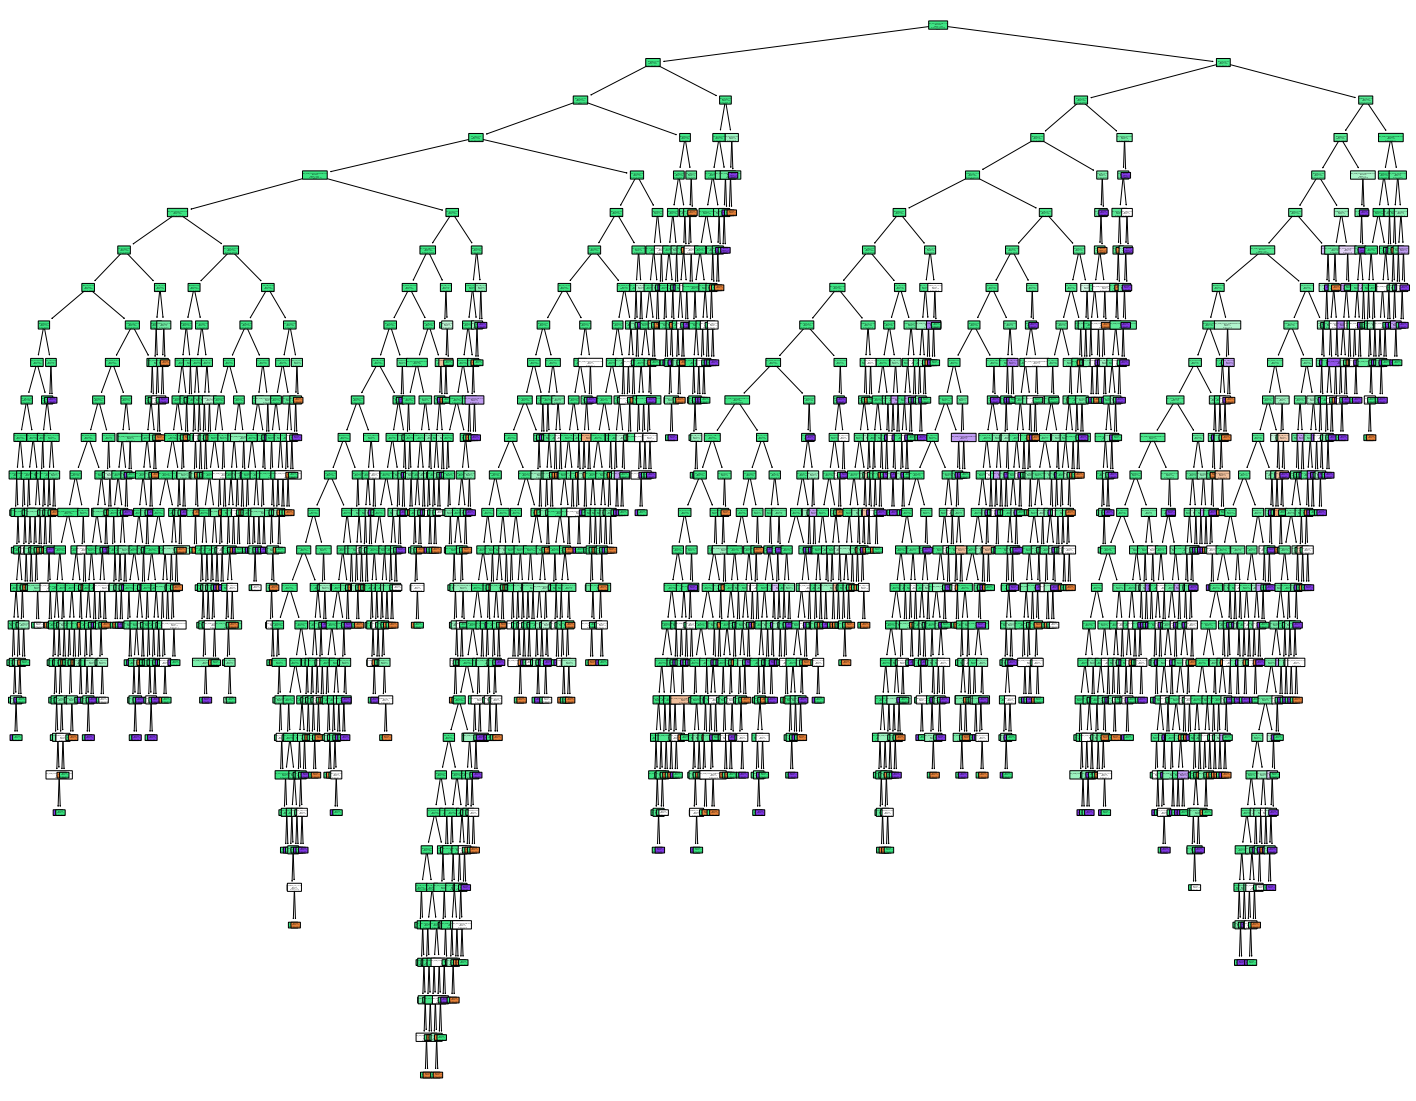

In [205]:
fig = plt.figure(figsize=(25,20))

#tree.plot_tree(pipeline['decisionTree'],filled=True,fontsize=12,feature_names=list(cat_X))
#tree.plot_tree(clf,filled=True,fontsize=12,feature_names=list(X.columns),class_names=list(str(df['STATUS'])))
tree.plot_tree(clf, filled=True, feature_names=encoder.get_feature_names_out(X_train.columns), class_names=list(str(df['STATUS'])), rounded=True)

plt.show

In [206]:
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
     

In [207]:
dt_classifier = DecisionTreeClassifier(criterion='entropy')
dt_classifier.fit(X_train_encoded, y_train)
y_predict_dt = dt_classifier.predict(X_test_encoded)

print(classification_report(y_test, y_predict_dt))

              precision    recall  f1-score   support

           0       0.07      0.11      0.09       108
           1       0.98      0.96      0.97     10014
           2       0.12      0.18      0.15       165

    accuracy                           0.94     10287
   macro avg       0.39      0.42      0.40     10287
weighted avg       0.95      0.94      0.95     10287



In [209]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

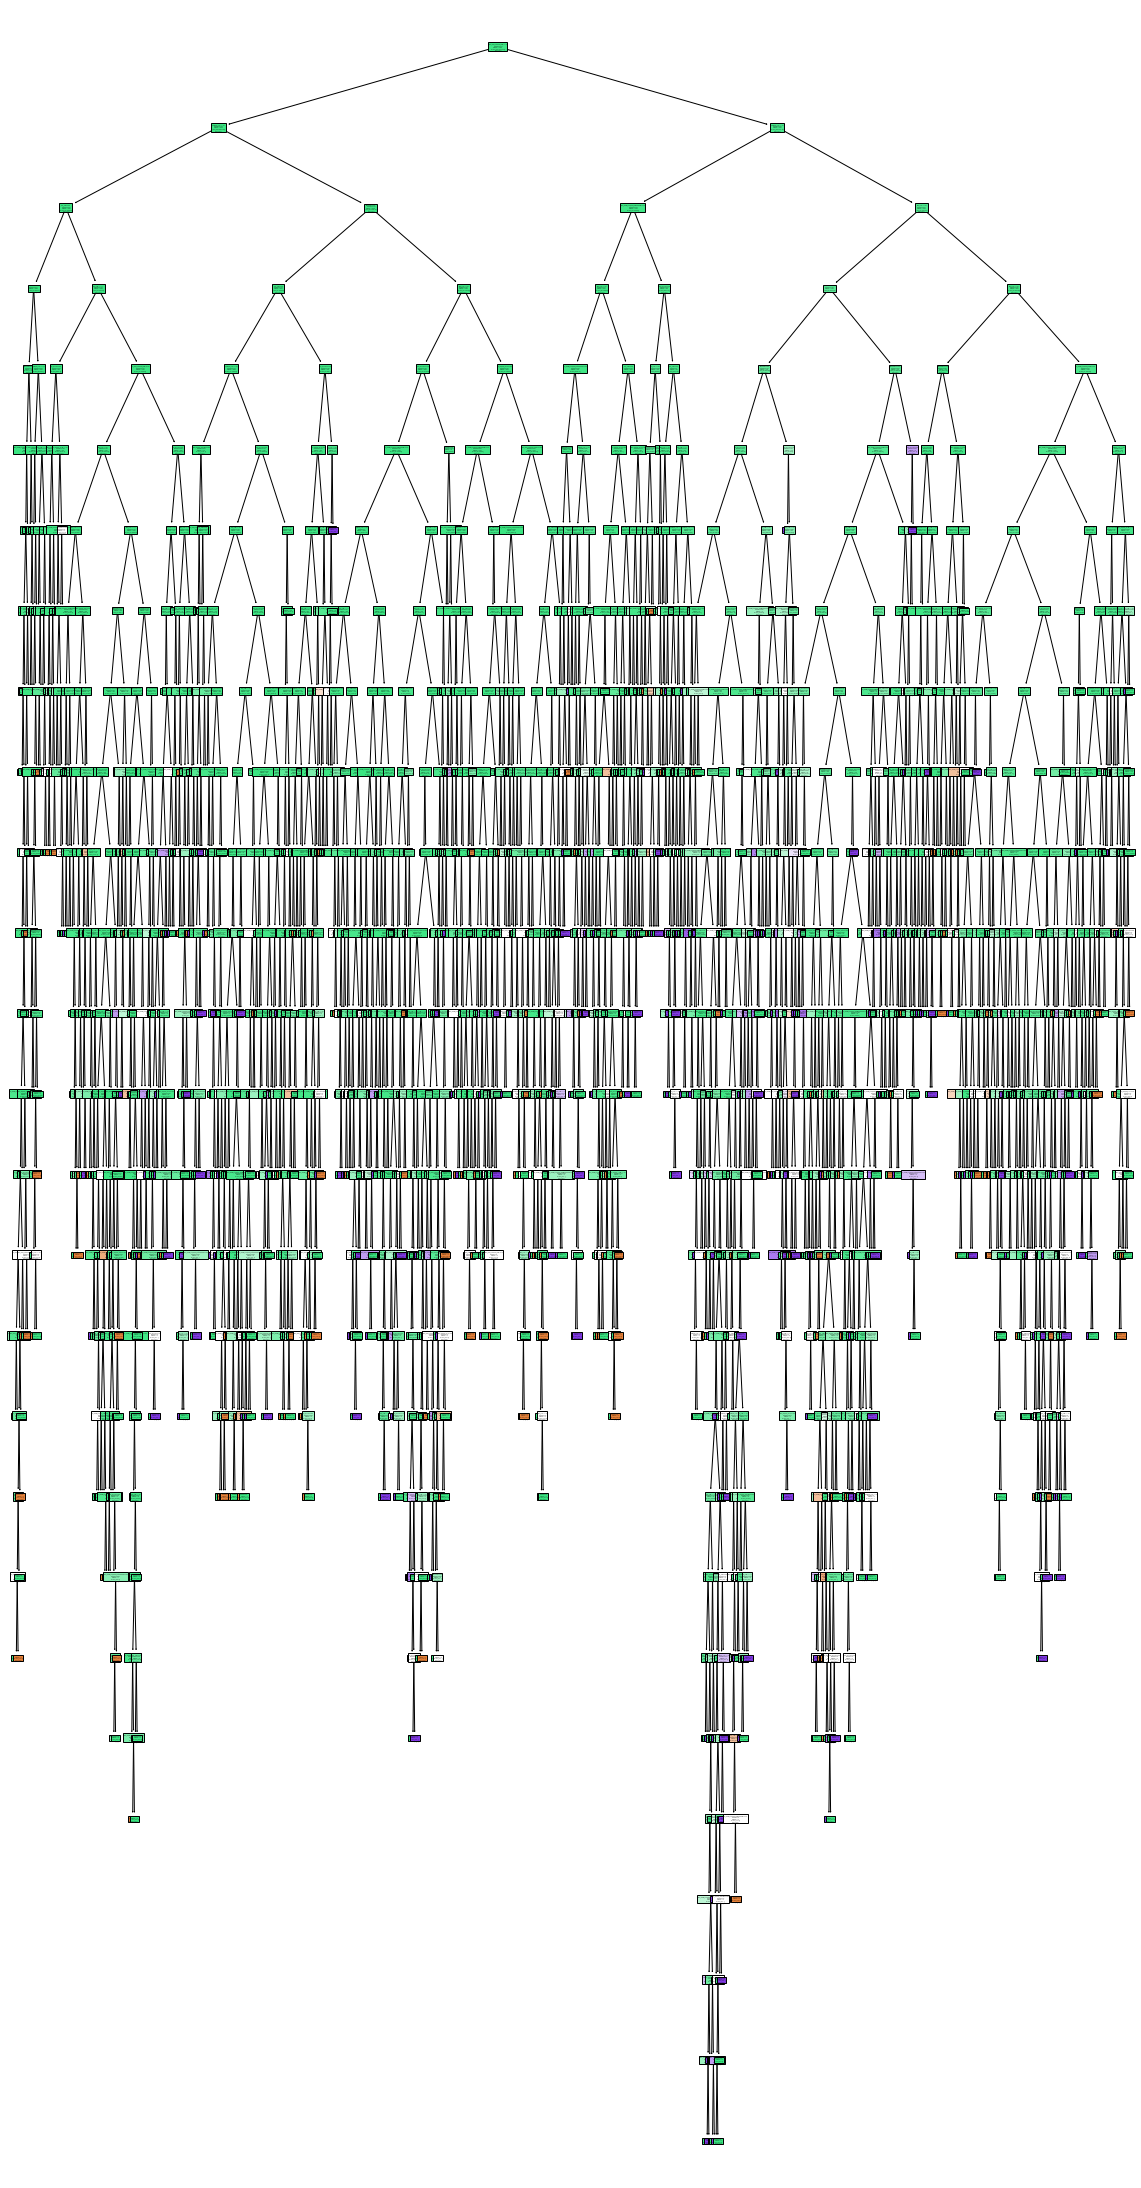

In [212]:
# Plotting the decision tree
plt.figure(figsize=(20, 40))
plot_tree(dt_classifier, filled=True, feature_names=list(X_train_encoded), class_names=True)
plt.show()

In [231]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [232]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame 'df' with columns 'day', 'month', 'year', 'OCC_TOD', 'OCC_DOW', 'OCC_MONTH', and 'risk'
# Replace this with your actual dataset and column names

# Example DataFrame:
# df = pd.DataFrame({'day': [1, 2, 3, 4, 5], 'month': [1, 1, 1, 2, 2], 'year': [2020, 2020, 2020, 2020, 2020], 'OCC_TOD': ['Night', 'Dawn', 'Night', 'Morning', 'Afternoon'], 'OCC_DOW': [1, 2, 3, 4, 5], 'OCC_MONTH': [1, 2, 3, 4, 5], 'risk': ['low', 'high', 'low', 'high', 'low']})


In [233]:
# Encoding categorical features
label_encoder = LabelEncoder()
df['OCC_TOD'] = label_encoder.fit_transform(df['OCC_TOD'])

In [244]:
# Splitting the data into training and testing sets
X = df[['OCC_TOD', 'OCC_DOW', 'OCC_MONTH']]
y = df['STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [245]:
# Creating and training the decision tree classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy',max_depth=6)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [246]:
# Convert feature names to strings
feature_names = [str(col) for col in X.columns]

In [247]:
# Convert class labels to strings
class_names = [str(label) for label in dt_classifier.classes_]

In [248]:
# Making predictions on the test set
y_predict_dt = dt_classifier.predict(X_test)

In [249]:
# Evaluating the model
print(classification_report(y_test, y_predict_dt))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.97      1.00      0.99     10014
           2       0.00      0.00      0.00       165

    accuracy                           0.97     10287
   macro avg       0.32      0.33      0.33     10287
weighted avg       0.95      0.97      0.96     10287



C:\Users\thezl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thezl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thezl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [250]:
# Plotting the decision tree (optional)
import matplotlib.pyplot as plt

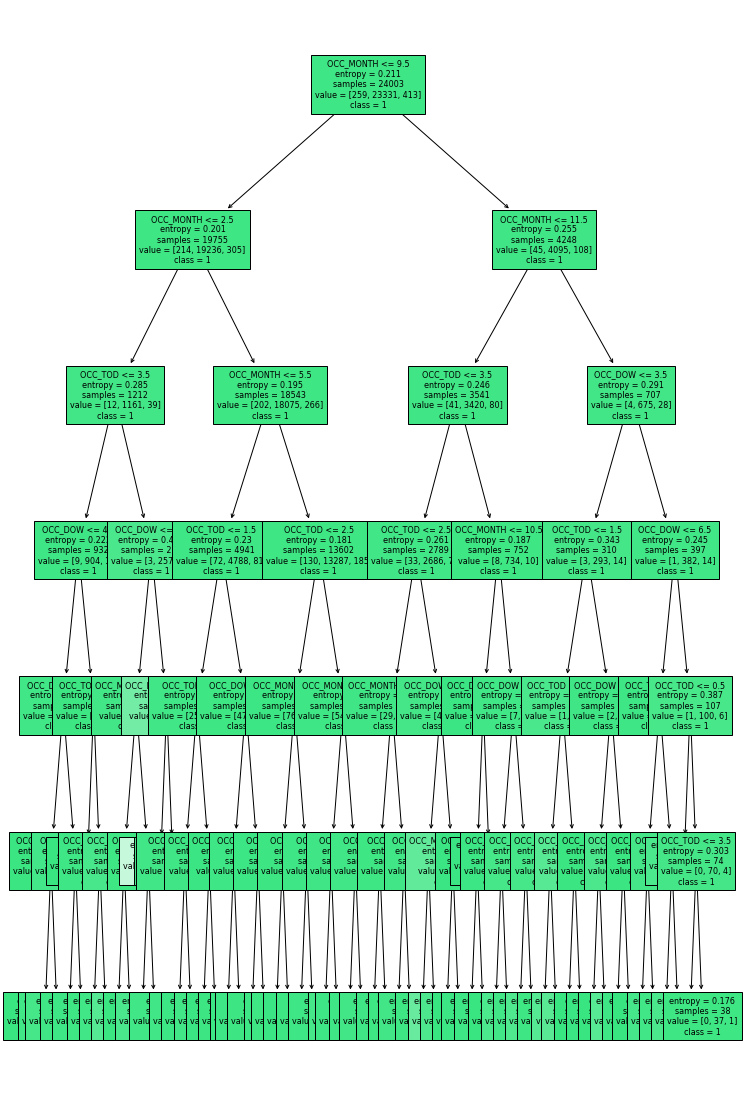

In [253]:
plt.figure(figsize=(12, 20))
plot_tree(dt_classifier, filled=True, feature_names=feature_names, class_names=class_names,fontsize=8)
plt.show()

In [255]:
from sklearn.tree import export_text

# Assuming X_train has the original features before one-hot encoding
tree_rules = export_text(dt_classifier, feature_names=list(X_train.columns))
print(tree_rules)

|--- OCC_MONTH <= 9.50
|   |--- OCC_MONTH <= 2.50
|   |   |--- OCC_TOD <= 3.50
|   |   |   |--- OCC_DOW <= 4.50
|   |   |   |   |--- OCC_DOW <= 1.50
|   |   |   |   |   |--- OCC_TOD <= 2.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- OCC_TOD >  2.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- OCC_DOW >  1.50
|   |   |   |   |   |--- OCC_TOD <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- OCC_TOD >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- OCC_DOW >  4.50
|   |   |   |   |--- OCC_TOD <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OCC_TOD >  0.50
|   |   |   |   |   |--- OCC_DOW <= 6.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- OCC_DOW >  6.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- OCC_TOD >  3.50
|   |   |   |--- OCC_DOW <= 6.50
|   |   |   |   |--- OCC_MONTH <= 1.50
|   |   |   |   |   |--- OCC_DOW <= 4.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |  